In [1]:
%load_ext cython
import pyrost as rst
# import speckle_tracking as st
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
from multiprocessing import cpu_count
from importlib import reload
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, siunitx}'
# plt.rcParams['text.usetex'] = 'True'


pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2babf1da2110>)

In [56]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'dot', 'make_reference', 'median_filter', 'np', 'st', 'st_update', 'tensordot']


In [62]:
params = st_sim.STParams.import_default(bar_size=0.3, bar_sigma=0.05, bar_atn=0.38,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                                        n_frames=100, defocus=40, alpha=0.04, ab_cnt=0.7,
                                        step_size=0.15, step_rnd=0.8, seed=8457259)
st_conv = st_sim.STConverter()
%time sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

CPU times: user 18.9 s, sys: 1.39 s, total: 20.3 s
Wall time: 366 ms


In [63]:
st_obj = data.get_st()

st_obj = st_obj.update_reference(ls_ri=8.)
# st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

In [64]:
%time I0, n0, m0 = rst.bin.make_reference(st_obj.data, st_obj.whitefield, st_obj.pixel_map, st_obj.dss_pix, \
                                          st_obj.dfs_pix, 0, 0, 8., True, 64)

CPU times: user 286 ms, sys: 3.93 ms, total: 290 ms
Wall time: 9.53 ms


In [65]:
%time I0, n0, m0 = dev.make_reference(st_obj.data, st_obj.whitefield, st_obj.pixel_map, st_obj.dss_pix, \
                                st_obj.dfs_pix, 8., 64)

CPU times: user 1min 56s, sys: 373 ms, total: 1min 57s
Wall time: 1.83 s


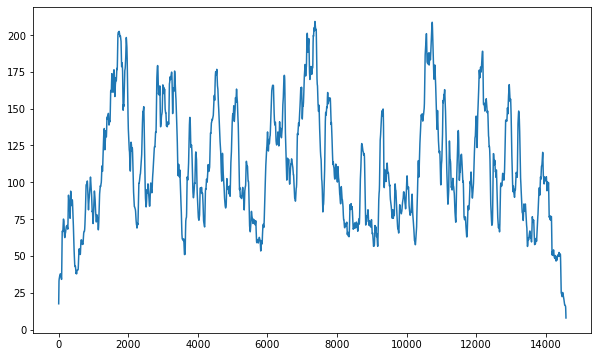

In [66]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(I0[0])
# ax.plot(np.linspace(0, 1, M), np.abs(np.fft.fft(plan.f)))
# ax.plot(np.fft.ifft(np.fft.fftshift(f_hat)))
# ax.plot(f_hat_2.real)
plt.show()

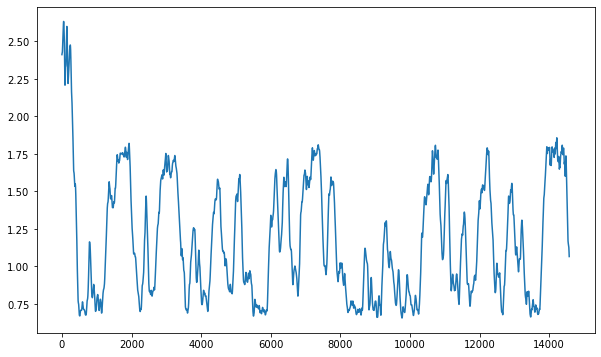

In [67]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.abs(st_obj.reference_image[0]))
plt.show()

# Multislice

In [7]:
# Recipe simulation

en = 17.48e3
wl = st_sim.MLL.en_to_wl / en
n_min = 700
mll_mat1 = st_sim.Material(formula='SiC', density=2.67)
mll_mat2 = st_sim.Material(formula='WC', density=13.87)
params = st_sim.MSParams.import_default(x_step=1e-4, z_step=9e-3, n_min=n_min, n_max=n_min + 21710,
                                        focus=1.25e3, mll_sigma=2e-4, mll_wl=wl, wl=wl, x_min=5., x_max=45.,
                                        mll_depth=9.33, mll_mat1=mll_mat1, mll_mat2=mll_mat2)
mll = st_sim.MLL.import_params(params)

d_n = np.loadtxt('results/mll_recipe/MLL_profiles-02.txt') * 8e-4
params.focus = 8e2
d_lyr = np.repeat(d_n / 2, 2)
z_coords = params.z_step * np.arange(params.mll_depth // params.z_step)
mll.layers = (np.cumsum(d_lyr) + 8.) - z_coords[:, None] * np.repeat(params.mll_wl / 2 / d_n, 2)
print(d_n.shape, mll.layers.shape, mll.layers.min(), mll.layers.max())
print(mll.layers.shape)

(10854,) (1036, 21708) 7.958910772998954 36.063417825360034
(1036, 21708)


In [109]:
# Ideal MLL simulation

en = 60.0e3
wl = st_sim.MLL.en_to_wl / en
n_min, n_layers = 700, 20000
mll_mat1 = st_sim.Material(formula='SiC', density=2.67)
mll_mat2 = st_sim.Material(formula='WC', density=13.87)
params = st_sim.MSParams.import_default(x_step=1e-4, z_step=1e-2, n_min=n_min, n_max=n_min + n_layers,
                                        focus=2.5e3, mll_sigma=2e-4, mll_wl=wl, wl=wl, x_min=5., x_max=40.,
                                        mll_depth=60.0, mll_mat1=mll_mat1, mll_mat2=mll_mat2)
mll = st_sim.MLL.import_params(params)

ksize = 1e3
ms_prgt = st_sim.MSPropagator(params, mll)
wf_inc = gaussian_filter(ms_prgt.wf_inc.real, ksize) + 1j * gaussian_filter(ms_prgt.wf_inc.imag, ksize)
ms_prgt = ms_prgt.update_inc_wavefront(wf_inc)

ms_prgt.beam_propagate(verbose=True)
print(mll.layers.shape, mll.layers.min(), mll.layers.max())

   0%            Slice 0 / 5999 [00:00<?, ?it/s]

(5999, 20000) 5.941356003118587 32.701035785822185


In [325]:
# Multilayer simulation

en = 17.48e3
wl = st_sim.MLL.en_to_wl / en
mll_mat1 = st_sim.Material(formula='SiC', density=3.21)
mll_mat2 = st_sim.Material(formula='WC', density=15.63)
mll_d = 5e-3
params = st_sim.MSParams.import_default(x_step=1e-4, z_step=9e-3, n_min=5 / mll_d, n_max=25 / mll_d,
                                        mll_sigma=1e-4, wl=wl, x_min=0., x_max=30.,
                                        mll_depth=7.77, mll_mat1=mll_mat1, mll_mat2=mll_mat2)

layers = mll_d / 2 * np.arange(2 * params.n_min, 2 * params.n_max) * np.ones((int(params.mll_depth // params.z_step), 1))
mll = st_sim.MLL(mat1_r=params.get_mat1_r(en), mat2_r=params.get_mat2_r(en), sigma=params.mll_sigma,
                 layers=layers)

ms_prgt = st_sim.MSPropagator(params, mll)

bragg = np.sin(1.02 * params.wl / 2 / mll_d)
wf_inc = np.ones(ms_prgt.x_arr.shape, dtype=np.complex128)
wf_inc[(ms_prgt.x_arr < x_min) | (ms_prgt.x_arr > x_max)] = 0.
wf_inc = gaussian_filter(wf_inc.real, ksize) + 1j * gaussian_filter(wf_inc.imag, ksize)
wf_inc *= np.exp(2j * np.pi / params.wl * bragg * ms_prgt.x_arr)

ms_prgt = ms_prgt.update_inc_wavefront(wf_inc)
ms_prgt.beam_propagate(verbose=True)

(863, 8000)


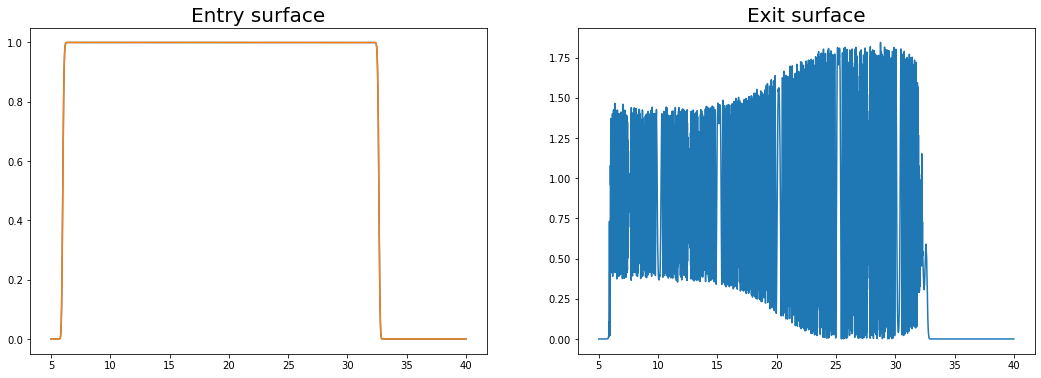

In [110]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(ms_prgt.x_arr[::100], np.abs(ms_prgt.beam_profile[0, ::100])**2)
axes[0].set_title('Entry surface', fontsize=20)
axes[0].plot(ms_prgt.x_arr[::100], np.abs(ms_prgt.wf_inc[::100])**2)
axes[1].plot(ms_prgt.x_arr[::100], np.abs(ms_prgt.beam_profile[-1, ::100])**2)
axes[1].set_title('Exit surface', fontsize=20)
plt.show()

In [95]:
w_pad = 100
wft = np.pad(ms_prgt.beam_profile[-1], (w_pad, w_pad))

focus_step = 2 * params.x_step
wft_focus = rsc_wp(wft, params.x_step, focus_step, params.focus - params.mll_depth, params.wl)[w_pad:-w_pad]
xfocus = focus_step * np.arange(-wft_focus.size // 2, wft_focus.size - wft_focus.size // 2)
xfocus += np.mean(ms_prgt.x_arr)

# det_dist = 2e5
# M = det_dist / params.focus * 4.
# far_step = M * params.x_step
# wft_far = fraunhofer_wp(wft, params.x_step, far_step, det_dist, params.wl)[w_pad:-w_pad]
# xfar = far_step * np.arange(-wft_far.size // 2, wft_far.size - wft_far.size // 2) + np.mean(ms_prgt.x_arr)

In [133]:
wfts_foc, xs_foc = {}, {}
for z, wft in zip(ms_prgt.z_arr[::100], ms_prgt.beam_profile[::100]):

    foc_step = 2 * params.x_step
    wft_foc = rsc_wp(wft, params.x_step, foc_step, params.focus - z, params.wl)
    x_foc = foc_step * np.arange(-wft_foc.size // 2, wft_foc.size - wft_foc.size // 2) + np.mean(ms_prgt.x_arr)
    
    wfts_foc[z] = wft_foc
    xs_foc[z] = x_foc

In [143]:
sums = np.array([np.sum(np.abs(wft_foc[(x_foc > 44.99) & (x_foc < 45.01)])**2) for wft_foc in wfts_foc.values()])

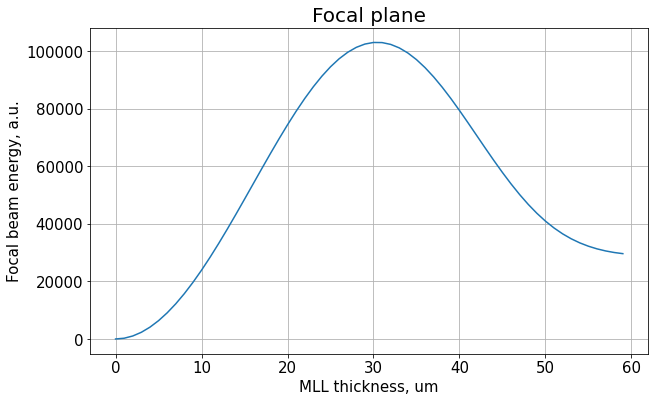

In [144]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(list(wfts_foc), sums)
axes.set_title('Focal plane', fontsize=20)
axes.set_xlabel('MLL thickness, um', fontsize=15)
axes.set_ylabel('Focal beam energy, a.u.', fontsize=15)
axes.tick_params(labelsize=15)
axes.grid(True)
plt.show()

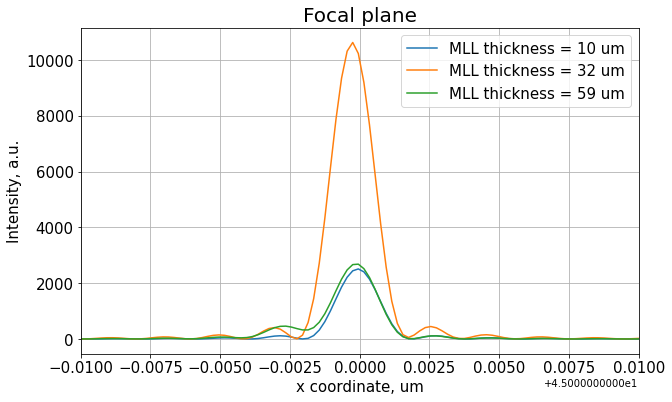

In [145]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
for z in [10, 32, 59]:
    axes.plot(xs_foc[z], np.abs(wfts_foc[z])**2, label=f'MLL thickness = {z} um')
axes.legend(fontsize=15)
axes.set_xlim(44.99, 45.01)
axes.set_title('Focal plane', fontsize=20)
axes.set_xlabel('x coordinate, um', fontsize=15)
axes.set_ylabel('Intensity, a.u.', fontsize=15)
axes.tick_params(labelsize=15)
axes.grid(True)
plt.show()

In [37]:
from pyrost.aberrations_fit import LeastSquares

x_min, x_max = 16.5, 35.
x_beam = xfocus[(xfocus > x_min) & (xfocus < x_max)]
theta = (x_beam - x_min) / params.focus

mag = np.abs(wft_focus[(xfocus > x_min) & (xfocus < x_max)])**2
phase = np.unwrap(np.angle(wft_focus[(xfocus > x_min) & (xfocus < x_max)]))

quad_fit = LeastSquares.fit(theta, phase, max_order=2)[0]
aber = phase - LeastSquares.model(quad_fit, theta, (0, x_beam.size))

ab_fit = LeastSquares.fit(theta, aber, max_order=4)[0]

In [274]:
from pyrost.aberrations_fit import LeastSquares

# x_min, x_max = 161, 196.
x_min, x_max = 143, 171
x_beam = x_arr[(x_arr > x_min) & (x_arr < x_max)]
theta = (x_beam - x_arr.mean()) / params.focus
# theta = (x_arr[(x_arr > x_min) & (x_arr < x_max)]) / params.focus
mag = np.abs(ds_beam[:, 99][(x_arr > x_min) & (x_arr < x_max)])**2
phase = np.unwrap(np.angle(ds_beam[:, 99][(x_arr > x_min) & (x_arr < x_max)]))

quad_fit = LeastSquares.fit(theta, phase, max_order=2)[0]
aber = phase - LeastSquares.model(quad_fit, theta, (0, x_beam.size))

ab_fit = LeastSquares.fit(theta, aber, max_order=4)[0]

In [275]:
defocus = quad_fit[-3] * params.wl / np.pi
ab_fit[-4] * 1e-9, ab_fit[-5] * 1e-12

(-0.33787150185646525, 0.0013680344286004494)

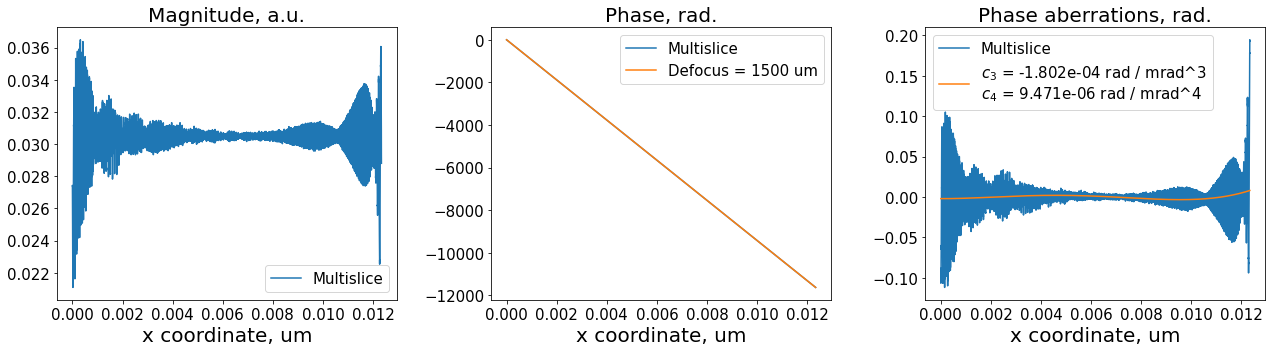

In [38]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(theta, mag, label='Multislice')
axes[0].set_title('Magnitude, a.u.', fontsize=20)
axes[1].plot(theta, phase, label='Multislice')
axes[1].plot(theta, LeastSquares.model(quad_fit, theta, (0, x_beam.size)),
             label=f'Defocus = {params.focus:.0f} um')
axes[1].set_title('Phase, rad.', fontsize=20)
axes[2].plot(theta, aber, label='Multislice')
axes[2].plot(theta, LeastSquares.model(ab_fit, theta, (0, x_beam.size)),
             label=f'$c_3$ = {ab_fit[-4] * 1e-9:.3e} rad / mrad^3\n$c_4$ = {ab_fit[-5] * 1e-12:.3e} rad / mrad^4')
axes[2].set_title('Phase aberrations, rad.', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, um', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [31]:
z_arr = np.linspace(0.1 * params.focus, 2. * params.focus, 50)
ds_beam, x_arr = ms_prgt.beam_downstream(z_arr, 1.5 * params.x_step)

  0%|          | 0/50 [00:00<?, ?it/s]

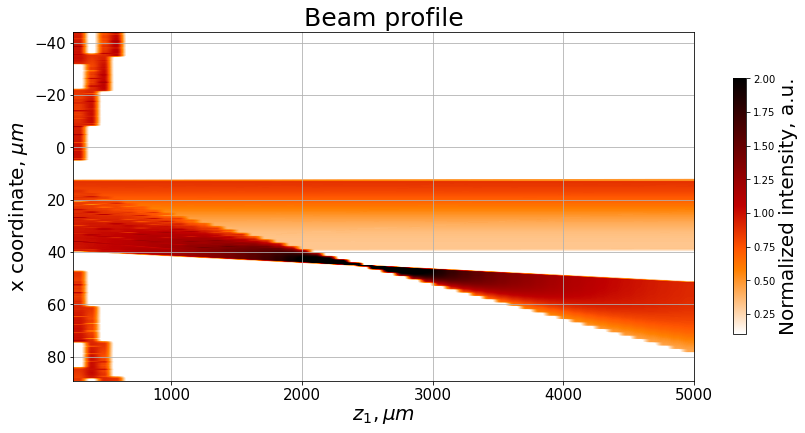

In [35]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im1 = ax.imshow(np.abs(ds_beam[::100]), vmin=0.1, vmax=2., cmap='gist_heat_r',
                extent=[z_arr.min(), z_arr.max(), x_arr.max(), x_arr.min()])
cbar = fig.colorbar(im1, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('Normalized intensity, a.u.', fontsize=20)
ax.set_title('Beam profile', fontsize=25)
ax.set_ylabel(r'x coordinate, $\mu m$', fontsize=20)
ax.set_aspect(20)
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$z_1, \mu m$', fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.show()

# Beamtime preparation

In [7]:
data_obj = data_obj.crop_data((0, data.shape[1], 0, 1400))
data_obj = data_obj.update_mask(pmax=99.999)

size = 5
kernel = np.ones(int(size)) / size
mean = data_obj.whitefield.copy()
mean = fft_convolve(mean, kernel, mode='reflect', axis=0)
mean = fft_convolve(mean, kernel, mode='reflect', axis=1)
mean_sq = data_obj.whitefield**2
mean_sq = fft_convolve(mean_sq, kernel, mode='reflect', axis=0)
mean_sq = fft_convolve(mean_sq, kernel, mode='reflect', axis=1)

In [82]:
r_image = mean_sq - mean**2
r_min = np.max(r_image[:, :50])
r_max = np.max(r_image)
r_image = np.clip(r_image, r_min, r_max) - r_min

In [87]:
from scipy.ndimage import label, generate_binary_structure, sum_labels

s = generate_binary_structure(size, size)
labels, num_labels = label(r_image)
fbeam_lbl, db_lbl = np.argsort(sum_labels(r_image, labels, np.arange(num_labels + 1)))[-2:]
ss_arr, fs_arr = np.where(labels == fbeam_lbl)
roi = np.array([ss_arr.min(), ss_arr.max(), fs_arr.min()])

(array([271, 271, 271, ..., 292, 292, 292]),
 array([ 562,  563,  564, ..., 1253, 1254, 1255]))

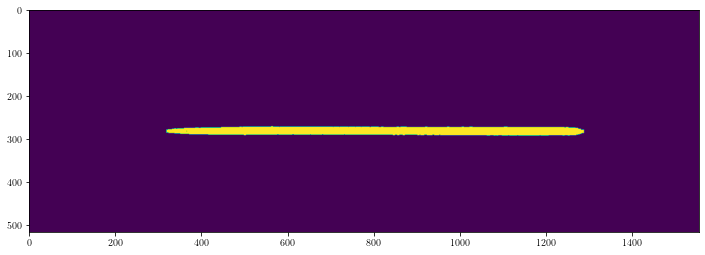

In [84]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 6))
# axes.imshow(data_obj.whitefield, vmax=100)
axes.imshow(labels == fbeam_lbl, vmax=1)
plt.show()

# ST Simulation

In [3]:
params = st_sim.STParams.import_default(bar_size=0.7, bar_sigma=0.18, bar_atn=0.18,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                                        n_frames=200, defocus=40, alpha=0.04, ab_cnt=0.7,
                                        step_size=0.15, step_rnd=0.8, seed=8457259)

globals().update(**params.export_dict())
print(params)

{'exp_geom': {'defocus': 40.0, 'det_dist': 2000000.0, 'n_frames': 200, 'step_size': 0.15, 'step_rnd': 0.8}, 'detector': {'fs_size': 2000, 'pix_size': 55.0, 'ss_size': 1000}, 'source': {'p0': 50000.0, 'th_s': 0.00015, 'wl': 7.29e-05}, 'lens': {'alpha': 0.04, 'ap_x': 40.0, 'ap_y': 2.0, 'focus': 1500.0, 'ab_cnt': 0.7}, 'barcode': {'bar_atn': 0.18, 'bar_rnd': 0.9, 'bar_sigma': 0.18, 'bar_size': 0.7, 'bulk_atn': 0.15, 'offset': 0.0}, 'system': {'num_threads': 64, 'seed': 8457259}}


In [4]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

58527 1508


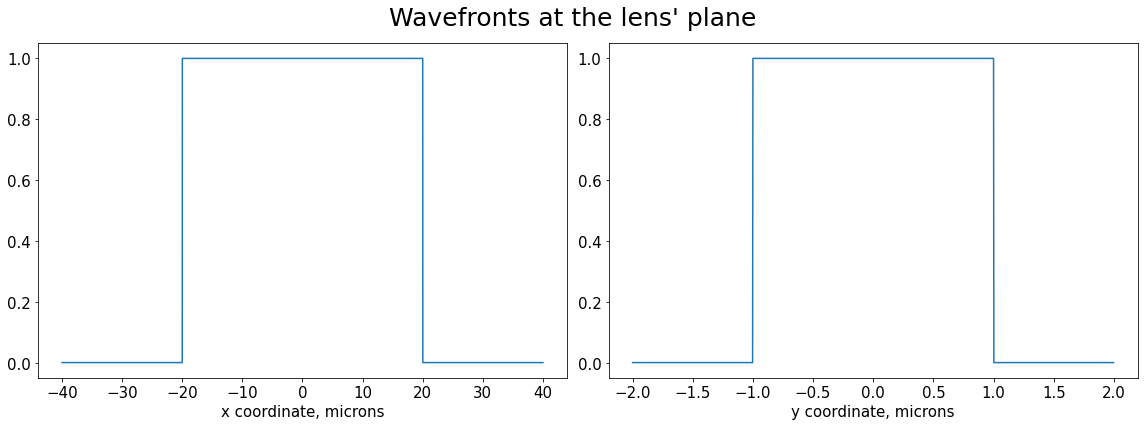

In [5]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [6]:
dx1, dy1 = dx0 * params.defocus / params.focus, dy0
z01 = params.focus + params.defocus
%time defoc_wfx = dev.rsc_wp(lens_wfx, dx0, dx1, z01, params.wl, num_threads=1)
%time defoc_wfy = dev.rsc_wp(lens_wfy, dy0, dy1, z01, params.wl, num_threads=12)

CPU times: user 31.9 ms, sys: 1.43 ms, total: 33.3 ms
Wall time: 34 ms
CPU times: user 1.27 ms, sys: 288 µs, total: 1.55 ms
Wall time: 1.33 ms


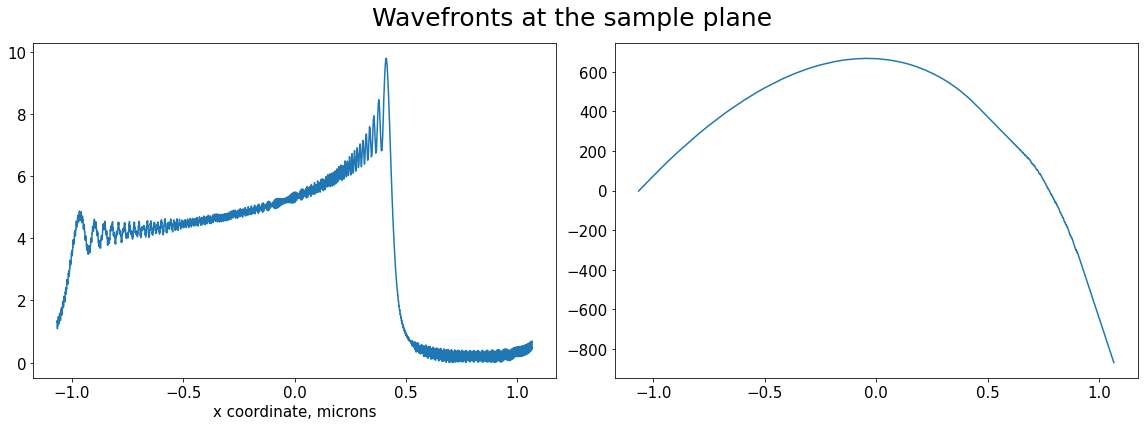

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dx1 * nx_arr, np.unwrap(np.angle(defoc_wfx)))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [8]:
x0, x1 = params.beam_span(params.defocus)
x1 += params.step_size * params.n_frames
bar_pos = dev.bar_positions(x0 + params.offset, x1 - params.offset, params.bar_size, 2 * params.bar_rnd, params.seed)

In [9]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
%time b_tr = dev.barcode_profile(x_arr=x_arr, bars=bar_pos, bulk_atn=params.bulk_atn, \
                                 bar_atn=params.bar_atn, bar_sigma=params.bar_sigma, \
                                 num_threads=32)
smp_wfx = defoc_wfx * b_tr

CPU times: user 4.03 s, sys: 179 ms, total: 4.21 s
Wall time: 141 ms


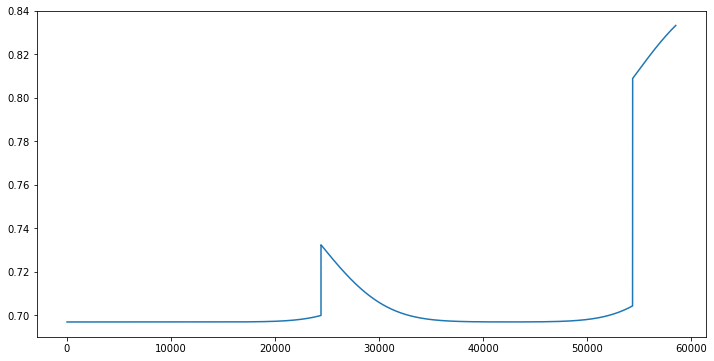

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.abs(b_tr[10]))
plt.show()

In [11]:
dx2, dy2 = params.fs_size * params.pix_size / n_x, params.ss_size * params.pix_size / n_y
%time det_wfx = dev.fraunhofer_wp(smp_wfx, dx1, dx2, params.det_dist, params.wl, num_threads=12)
%time det_wfy = dev.fraunhofer_wp(defoc_wfy, dy1, dy2, params.det_dist, params.wl, num_threads=12)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 4.33 s, sys: 122 ms, total: 4.45 s
Wall time: 371 ms
CPU times: user 8.55 ms, sys: 0 ns, total: 8.55 ms
Wall time: 703 µs
(200, 58527) (200, 58527)


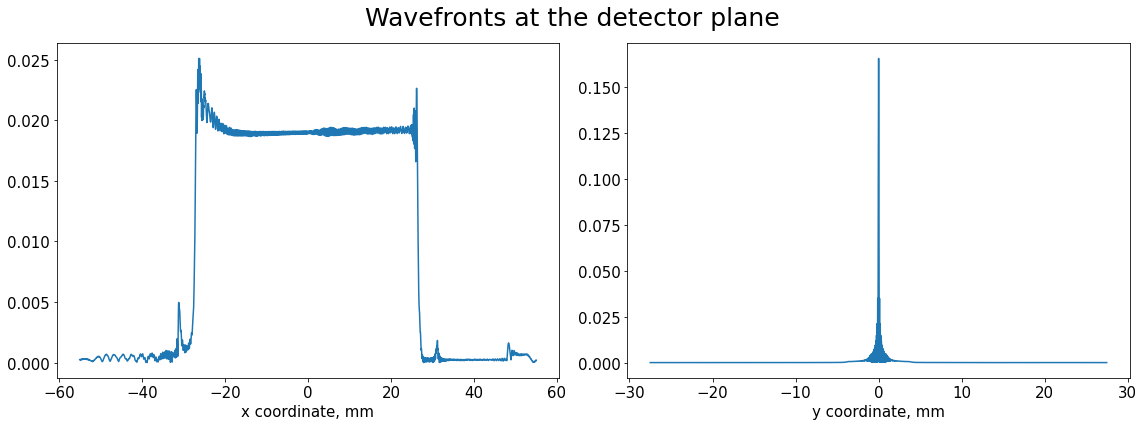

In [12]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[2]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [13]:
sc_x = params.source_curve(params.defocus + params.det_dist, dx2)
sc_y = params.source_curve(params.defocus + params.det_dist, dy2)
pfx = np.sqrt(params.p0) / params.ap_x * np.abs(det_wfx)**2
pfy = np.sqrt(params.p0) / params.ap_y * np.abs(det_wfy)**2
print(pfx.shape, sc_x.shape)
%time det_ix = dev.fft_convolve(pfx, sc_x, num_threads=12)
%time det_iy = dev.fft_convolve(pfy, sc_y, num_threads=12)
# print(det_ix.shape, det_iy.shape)

(200, 58527) (1277,)
CPU times: user 713 ms, sys: 27.2 ms, total: 740 ms
Wall time: 61.8 ms
CPU times: user 1.69 ms, sys: 864 µs, total: 2.56 ms
Wall time: 232 µs


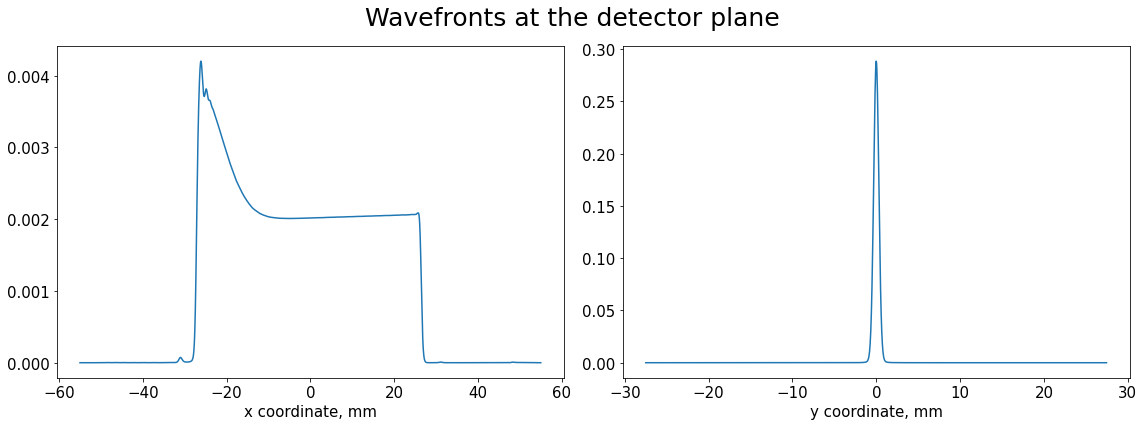

In [14]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, det_ix[0])
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, det_iy)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [18]:
wfx = np.ones(params.fs_size)
wfy = np.ones(params.ss_size)
%time frames = dev.make_frames(pfx=det_ix, pfy=det_iy, dx=dx2, dy=dy2, \
                               shape=(params.ss_size, params.fs_size), \
                               seed=params.seed, num_threads=16)
%time wfield = dev.median(frames, axis=0, num_threads=64)
frames.shape, wfield.shape

CPU times: user 20.3 s, sys: 1.25 s, total: 21.6 s
Wall time: 1.35 s
CPU times: user 18.5 s, sys: 586 ms, total: 19.1 s
Wall time: 384 ms


((200, 1000, 2000), (1000, 2000))

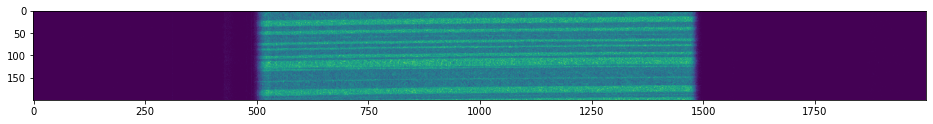

In [19]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(16, 6))
axes.imshow(frames.sum(axis=1))
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [60]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'dot', 'make_reference', 'median_filter', 'np', 'st', 'st_update', 'tensordot']


In [3]:
params = st_sim.STParams.import_default(bar_size=0.3, bar_sigma=0.05, bar_atn=0.38,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                                        n_frames=20, defocus=40, alpha=0.04, ab_cnt=0.7,
                                        step_size=0.15, step_rnd=0.8, seed=8457259)
st_conv = st_sim.STConverter()
%time sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

CPU times: user 8.52 s, sys: 464 ms, total: 8.98 s
Wall time: 222 ms


In [6]:
ds_scan, extra = data.defocus_sweep(np.linspace(20e-6, 100e-6, 20), return_extra=True)

Generating defocus sweep:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
st_obj = data.get_st()

st_obj = st_obj.update_reference(ls_ri=8.)
# st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

In [6]:
from pynfft.nfft import NFFT

plan = NFFT(100, st_obj.whitefield.size)

In [7]:
u_max, u_min = st_obj.pixel_map[1, 0].max(), st_obj.pixel_map[1, 0].min()
plan.x = (st_obj.pixel_map[1, 0] - u_min) / (u_max - u_min) - 0.5
plan.f = (st_obj.data[0] * st_obj.whitefield).ravel()

In [ ]:
f_hat = plan.adjoint()

In [56]:
%time I0, n0, m0 = dev.make_reference(st_obj.data, st_obj.whitefield, st_obj.pixel_map, st_obj.dss_pix, \
                                st_obj.dfs_pix, 1.0, 1)

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 1.57 ms


In [57]:
I0[0, -1]

24.839484696748443

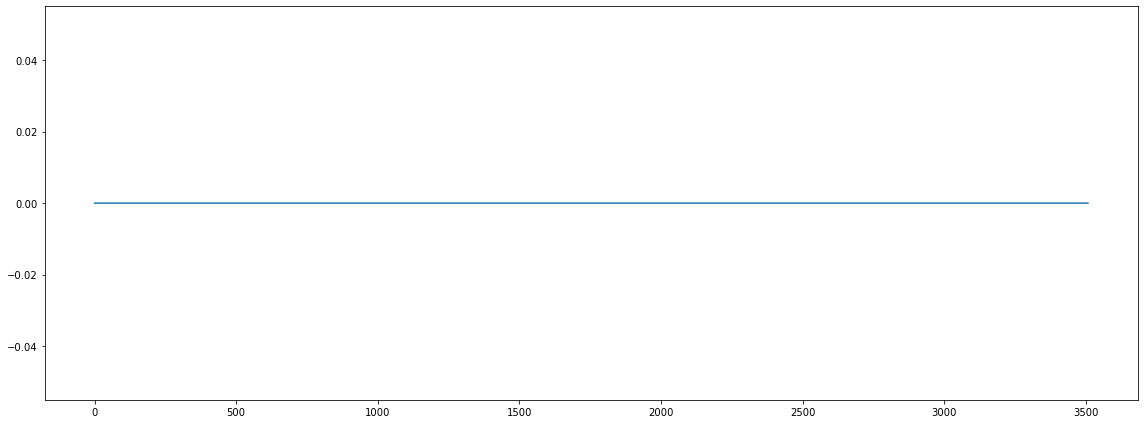

In [20]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
axes.plot(f_hat)
# axes.plot(st_res.reference_image[0], label='Dynamic h')
# axes.plot(st_obj.reference_image[0], label='Initial')
# axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
#              (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
# axes.set_title('Reference image', fontsize=20)
# axes[1].set_title('Pixel map', fontsize=20)
# for ax in axes:
#     ax.legend(fontsize=15)
#     ax.tick_params(labelsize=15)
#     ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [41]:
st_obj = data.get_st(num_threads=16)
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

Initial MSE = 0.440567, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.400667, ls_ri = 10.88
Iteration No. 2: Total MSE = 0.351141, ls_ri = 14.91
Iteration No. 3: Total MSE = 0.309532, ls_ri = 18.93
Iteration No. 4: Total MSE = 0.283405, ls_ri = 21.69
Iteration No. 5: Total MSE = 0.269093, ls_ri = 23.24
Iteration No. 6: Total MSE = 0.260826, ls_ri = 24.06
Iteration No. 7: Total MSE = 0.256253, ls_ri = 24.50
Iteration No. 8: Total MSE = 0.253984, ls_ri = 24.78
Iteration No. 9: Total MSE = 0.250753, ls_ri = 25.04
Iteration No. 10: Total MSE = 0.248626, ls_ri = 25.29
Iteration No. 11: Total MSE = 0.245684, ls_ri = 25.53
Iteration No. 12: Total MSE = 0.243465, ls_ri = 25.80
Iteration No. 13: Total MSE = 0.242260, ls_ri = 25.93
Iteration No. 14: Total MSE = 0.240375, ls_ri = 26.16
Iteration No. 15: Total MSE = 0.239756, ls_ri = 26.21
Iteration No. 16: Total MSE = 0.239550, ls_ri = 26.19
Iteration No. 17: Total MSE = 0.239581, ls_ri = 26.14


In [27]:
data = data.update_phase(st_res)
fit_obj = data.get_fit()
fit_obj.defocus = np.abs(fit_obj.defocus)
fit = fit_obj.fit()
ph_fit = fit_obj.fit_phase()

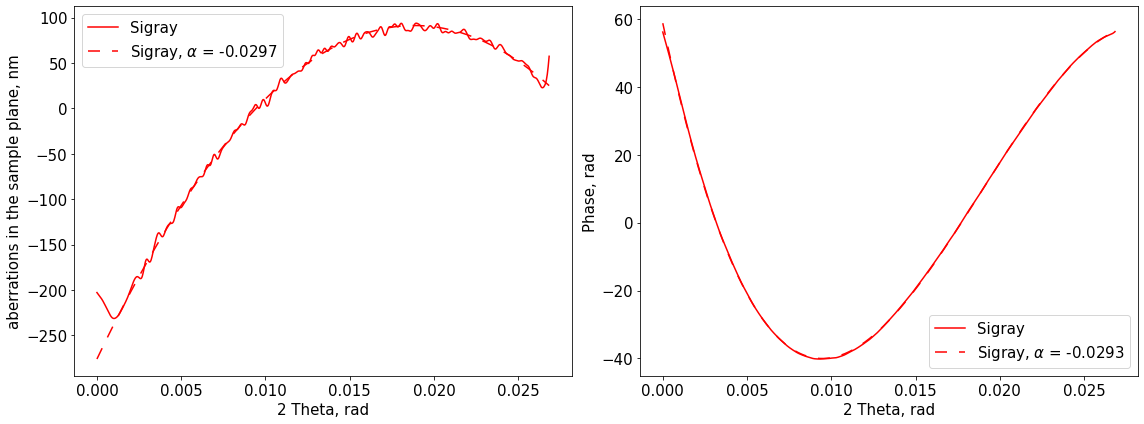

In [28]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap, fit_obj.model(ph_fit['ph_fit']), 
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(ph_fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Experimental results

In [4]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'dot', 'make_reference', 'median_filter', 'np', 'st', 'st_update', 'tensordot']


In [5]:
data_dict = {}
res = {}

In [60]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000),
            2797: (0, 1, 310, 1240), 2804: (0, 1, 180, 1220), 2894: (0, 1, 260, 1230), 2924: (0, 1, 250, 1200),
            2934: (0, 1, 320, 1240), 2936: (0, 1, 40, 1250), 2989: (0, 1, 200, 1245), 3029: (0, 1, 550, 1210),
            3254: (0, 1, 550, 1210)}

scan_num = 3476

data_dict[scan_num] = rst.cxi_converter_sigray(scan_num, target='Mo', distance=3.5)
data_dict[scan_num] = data_dict[scan_num].crop_data([200, 250, 440, 1220])
# data_dict[scan_num] = data_dict[scan_num].update_mask('range-bad', pmax=1000)
data_dict[scan_num] = data_dict[scan_num].integrate_data(axis=0).mask_frames()

# data_dict[scan_num]_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_{scan_num:d}/Scan_{scan_num:d}.cxi'
# loader = rst.CXILoader()
# data_dict[scan_num] = loader.load(data_dict[scan_num]_path.format(scan_num), roi=roi_dict[scan_num])

<IPython.core.display.Javascript object>


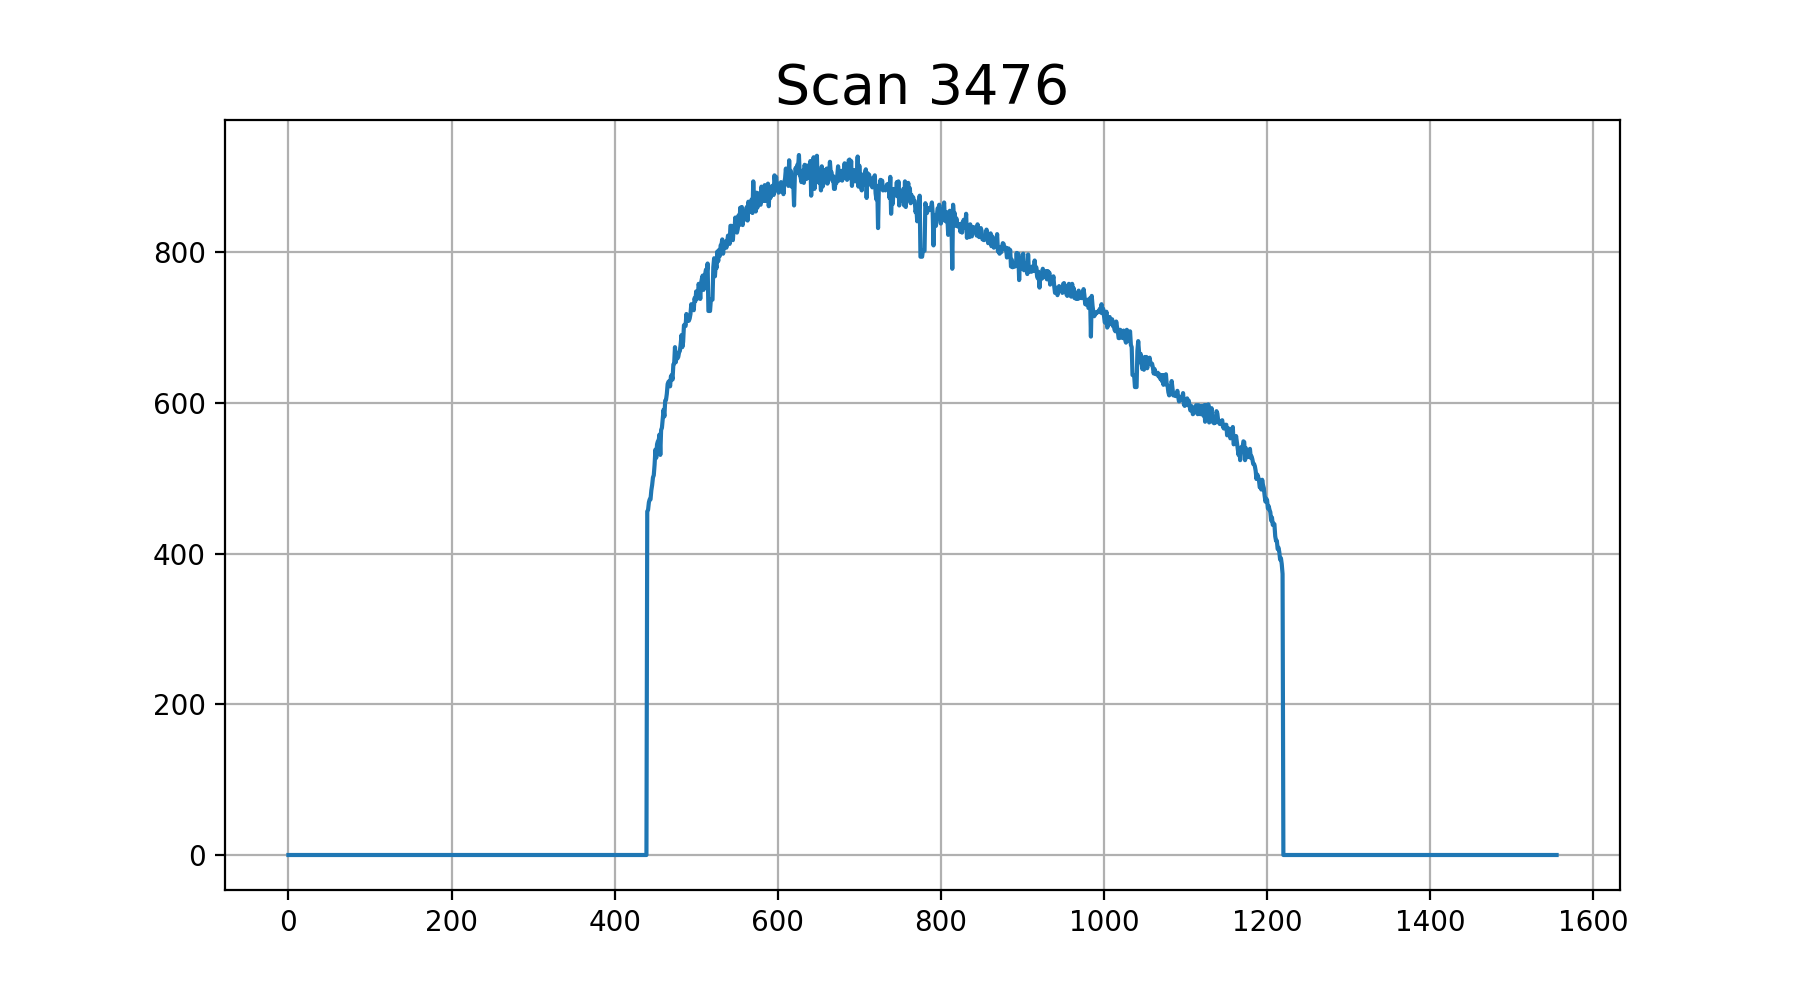

In [61]:
%matplotlib notebook
fig, axes = plt.subplots(figsize=(9, 5))
axes.plot(data_dict[scan_num].whitefield[0])
axes.set_title(f'Scan {scan_num:d}', fontsize=20)
axes.grid(True)
plt.show()

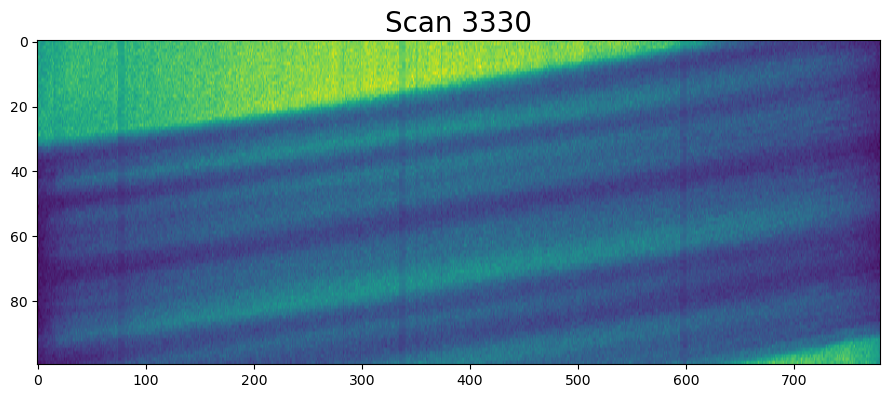

In [101]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(9, 6))
# axes.imshow(data_dict[scan_num].get('data')[0] * data_dict[scan_num].get('mask')[0], vmax=500)
axes.imshow(data_dict[scan_num].get('data')[:, 0], vmax=1000)
axes.set_title(f'Scan {scan_num:d}', fontsize=20)
axes.set_aspect(3)
plt.tight_layout()
plt.show()

In [102]:
scan_num = 3330
data_dict[scan_num] = data_dict[scan_num].mask_frames(np.arange(20, 100))

In [7]:
# roi = np.array([0, 1, 400, 1520])
# roi = np.array([0, 1, 160, 1160])
# data = rst.cxi_converter_sigray(3277)
data = data.integrate_data(axis=0)
# data = data.crop_data(roi)

In [885]:
data_low = rst.cxi_converter_sigray(3277)
fct = 2
data_low.basis_vectors *= fct
data_low.data = data_low.data[:, :, ::fct]
data_low.mask = data_low.mask[:, :, ::fct]
data_low.whitefield = data_low.whitefield[:, ::fct]
data_low.pixel_map = data_low.pixel_map[:, :, ::fct]
data_low.x_pixel_size *= fct
data_low.y_pixel_size *= fct
data_low = data_low.integrate_data(axis=0)
data_low = data_low.crop_data((0, 1, roi[2] // fct, roi[3] // fct))

In [886]:
np.mean(data.get('data').sum(axis=(1, 2))), np.mean(data_low.get('data').sum(axis=(1, 2)))

(5854.392156862745, 2941.1960784313724)

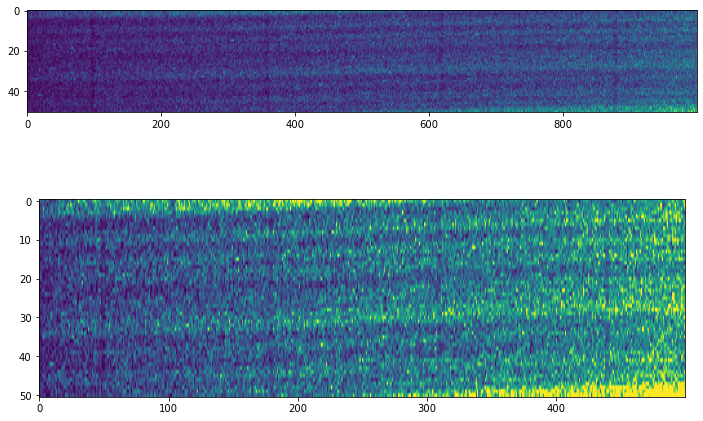

In [887]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].imshow(data.get('data')[:, 0], vmax=30)
axes[1].imshow(data_low.get('data')[:, 0], vmax=15)
for ax in axes:
    ax.set_aspect(3)
plt.show()

In [103]:
defoci = np.linspace(4e-5, 4e-4, 100)
ds_scan, extra = data_dict[scan_num].defocus_sweep(defoci, size=51, ls_ri=50, return_extra=True)

Generating defocus sweep:   0%|          | 0/100 [00:00<?, ?it/s]

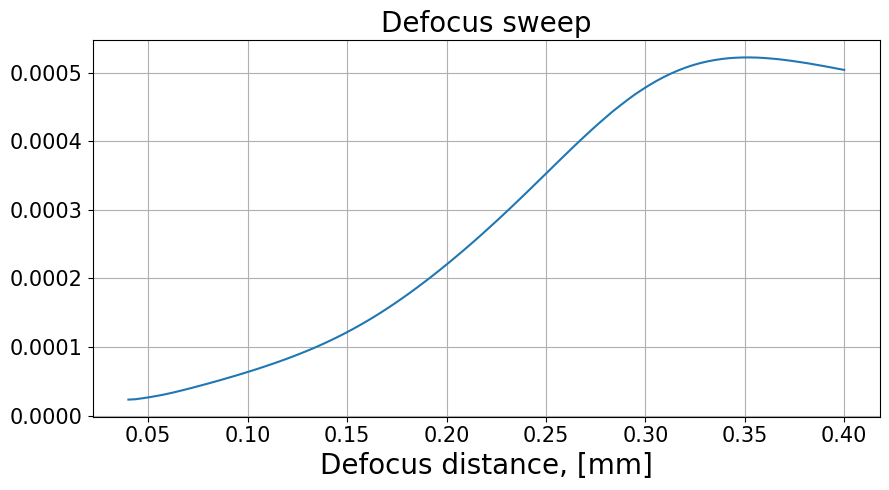

In [104]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(defoci * 1e3, ds_scan)
ax.set_title('Defocus sweep', fontsize=20)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.tick_params(labelsize=15)
ax.grid(True)
plt.tight_layout()
plt.show()

In [123]:
# data = data.update_defocus(defocus_fs=defocus_fs)
data_dict[scan_num] = data_dict[scan_num].update_defocus(defocus_fs=3.4e-4)

st_obj = data_dict[scan_num].get_st()

# st_rgd = st_obj.update_reference(ls_ri=10.)

st_rgd = st_obj.iter_update_gd(ls_ri=18., ls_pm=1., blur=22., sw_fs=200, n_iter=100, verbose=True,
                               learning_rate=1e0)

data_dict[scan_num] = data_dict[scan_num].update_phase(st_rgd)

   0%            Iteration 0 / 100 [00:00<?, ?it/s]

Initial MSE = 0.043440, Initial ls_ri = 18.00


In [106]:
res[scan_num] = dev.st_update(I_n=data_dict[scan_num].get('data').astype(np.float32),
                              dij=data_dict[scan_num].get('translations'),
                              basis=data_dict[scan_num].get('basis_vectors'),
                              x_ps=data_dict[scan_num].x_pixel_size,
                              y_ps=data_dict[scan_num].y_pixel_size, z=data_dict[scan_num].distance,
                              df=3.5e-4,
                              search_window=(1, 300), n_iter=5, filter=15.)

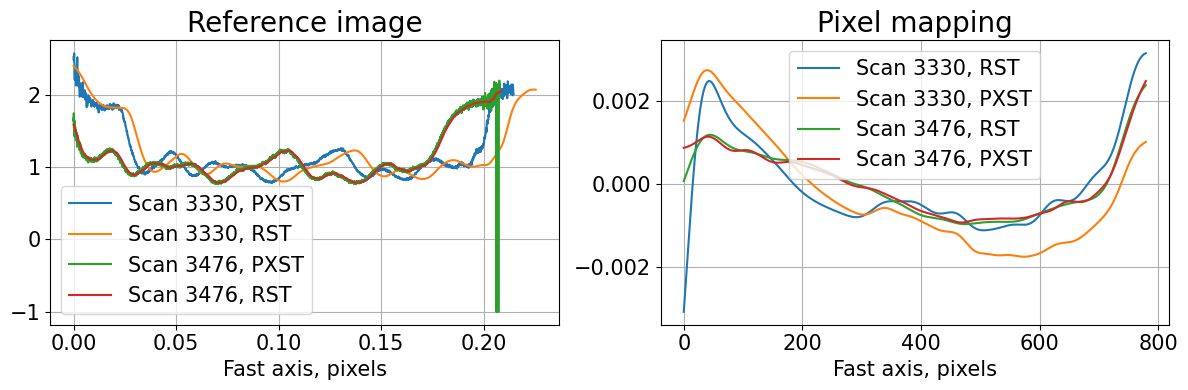

In [124]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for _scan_num in data_dict:
    if data_dict[_scan_num]._isdefocus:
        axes[0].plot(np.arange(res[_scan_num]['I0'].shape[1]) * 
                     data_dict[_scan_num].defocus_fs / data_dict[_scan_num].distance,
                     res[_scan_num]['I0'][0], label=f'Scan {_scan_num:d}, PXST')
        axes[0].plot(np.arange(data_dict[_scan_num].reference_image.shape[1]) * 
                     data_dict[_scan_num].defocus_fs / data_dict[_scan_num].distance,
                     data_dict[_scan_num].reference_image[0], label=f'Scan {_scan_num:d}, RST')
        axes[1].plot(data_dict[_scan_num].get('pixel_aberrations')[1, 0] * 
                     np.abs(data_dict[_scan_num].defocus_fs) / data_dict[_scan_num].distance,
                     label=f'Scan {_scan_num:d}, RST')
        axes[1].plot((res[_scan_num]['u'][1, 0] - np.arange(res[_scan_num]['u'].shape[-1])) *
                     data_dict[_scan_num].defocus_fs / data_dict[_scan_num].distance,
                     label=f'Scan {_scan_num:d}, PXST')
        axes[0].set_title('Reference image', fontsize=20)
        axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()

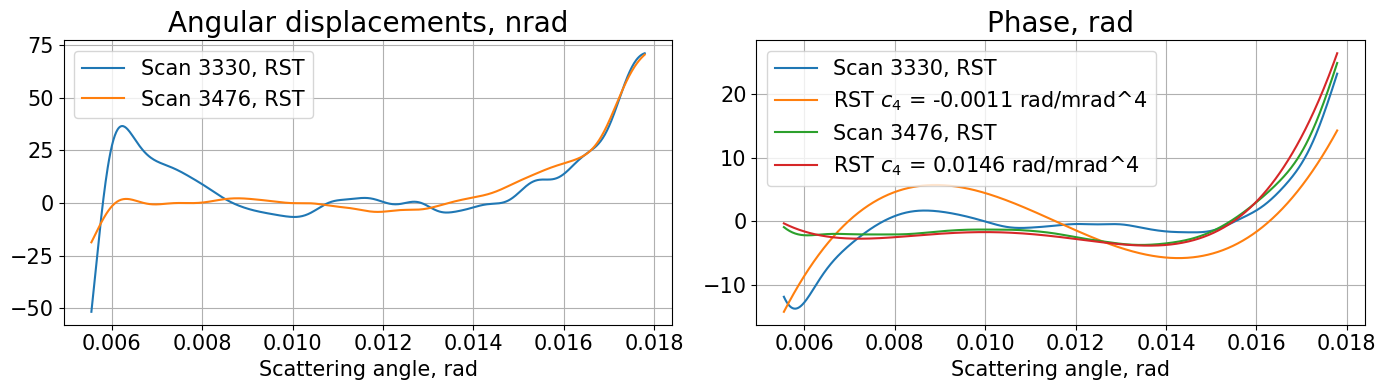

In [126]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for _scan_num in data_dict:
    if data_dict[_scan_num]._isdefocus:
        fit_obj = data_dict[_scan_num].get_fit(center=87).remove_linear_term()
        fit = fit_obj.fit(max_order=3, loss='cauchy')
        axes[0].plot(fit_obj.get('thetas'), fit_obj.get('theta_aberrations') * 1e9,
                     label=f'Scan {_scan_num:d}, RST')
#         axes[0].plot(fit_obj.get('thetas'),
#                      (res[_scan_num]['u'][1, 0] - np.arange(res[_scan_num]['u'].shape[-1]) - 28) *
#                      fit_obj.pixel_size * data_dict[scan_num].defocus_fs / fit_obj.distance**2 * 1e9,
#                      label=f'Scan {_scan_num:d}, PXST')
        axes[0].set_title('Angular displacements, nrad', fontsize=20)

        axes[1].plot(fit_obj.get('thetas'), fit_obj.get('phase'),
                     label=f'Scan {_scan_num:d}, RST')
        axes[1].plot(fit_obj.get('thetas'), fit_obj.model(fit['ph_fit']),
                     label=fr"RST $c_4$ = {fit['c_4']:.4f} rad/mrad^4")
    axes[1].set_title('Phase, rad', fontsize=20)
for ax in axes:
    ax.set_xlabel('Scattering angle, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [47]:
np.savetxt('test.txt', np.stack([fit_obj.get('thetas'), fit_obj.get('phase')], axis=1), fmt='%14.4f',
           header='[theta, rad]   [phase, rad]')

In [37]:
center = 20
fit_rst = data.get_fit(center=center).remove_linear_term()
fit_rst = fit_rst.crop_data([10, fit_rst.pixels.size - 30])
fcf_rst = fit_rst.fit(max_order=3, loss='linear')

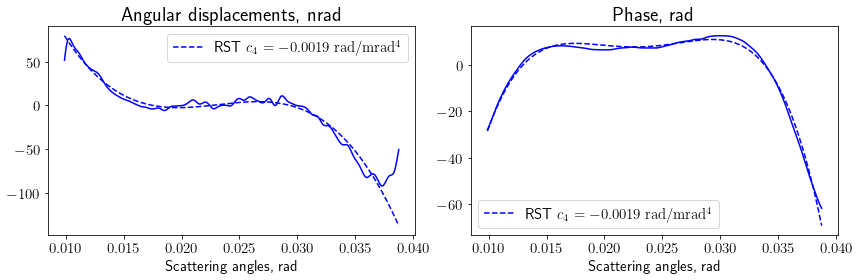

In [38]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(fit_rst.thetas, fit_rst.theta_aberrations * 1e9, 'b')
axes[0].plot(fit_rst.thetas, fit_rst.model(fcf_rst['fit']) * fit_rst.ref_ap * 1e9, 'b--',
             label=fr"RST $c_4 = {fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[0].set_title('Angular displacements, nrad', fontsize=20)

axes[1].plot(fit_rst.thetas, fit_rst.phase, 'b')
axes[1].plot(fit_rst.thetas, fit_rst.model(fcf_rst['ph_fit']), 'b--',
             label=fr"RST $c_4={fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[1].set_title('Phase, rad', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Scattering angles, rad', fontsize=15)
plt.tight_layout()
plt.show()

In [3]:
data_path = '/gpfs/cfel/cxi/data/2019/NSLS-2019_Bajt-Sep/cxifiles/scan_81763/scan_81763.cxi'
loader = rst.CXILoader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', pmax=99.995)

In [4]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
gb_images = []
ls_low = 1.
ls_high = 10.
for defocus in tqdm(df_nsls, total=len(df_nsls), desc='Generating defocus sweep'):
    st_obj = data_nsls.update_defocus(defocus).get_st().update_reference(ls_ri=1.5)
    grad_ss_high = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_low, 1),
                                axis=0, mode='reflect', num_threads=st_obj.num_threads)
    grad_ss_low = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_high, 1),
                               axis=0, mode='reflect', num_threads=st_obj.num_threads)
    grad_fs_high = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_low, 1),
                                axis=1, mode='reflect', num_threads=st_obj.num_threads)
    grad_fs_low = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_high, 1),
                               axis=1, mode='reflect', num_threads=st_obj.num_threads)
    mean_med = gaussian_filter(st_obj.reference_image, (ls_low + ls_high) / 2, mode='reflect',
                               num_threads=st_obj.num_threads)
    gb_image = ((grad_ss_high - grad_ss_low)**2 + (grad_fs_high - grad_fs_low)**2) / mean_med**2
    gb_images.append(gb_image)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

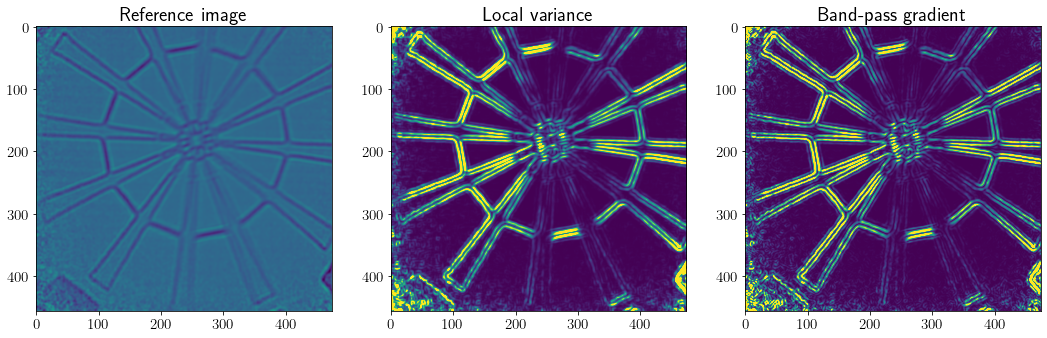

In [23]:
%matplotlib inline
idx = 15
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(extra['reference_image'][idx], vmax=1.5)
axes[0].set_title('Reference image', fontsize=20)
axes[1].imshow(extra['r_image'][idx], vmax=2e-3)
axes[1].set_title('Local variance', fontsize=20)
axes[2].imshow(gb_images[idx], vmax=1e-3)
axes[2].set_title('Band-pass gradient', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.show()

In [6]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls, extra = data_nsls.defocus_sweep(df_nsls, size=5., ls_ri=1.1, return_extra=True)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
gb_vals = np.array([np.mean(gb_image) for gb_image in gb_images])

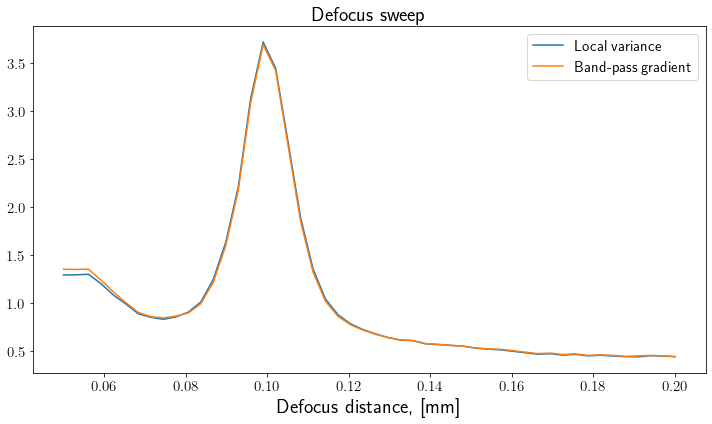

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_nsls * 1e3, dss_nsls / np.mean(dss_nsls), label='Local variance')
ax.plot(df_nsls * 1e3, gb_vals / np.mean(gb_vals), label='Band-pass gradient')
ax.set_title('Defocus sweep', fontsize=20)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [21]:
data_nsls = data_nsls.update_defocus(defocus_fs=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_ss=0, sw_fs=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, blur=6., sw_fs=3, sw_ss=3,
                                         n_iter=20, verbose=True, learning_rate=0.1)

   0%            Iteration 0 / 20 [00:00<?, ?it/s]

Initial MSE = 0.760687, Initial ls_ri = 1.10


In [22]:
data_nsls = data_nsls.update_phase(st_rgd_nsls)
fit_obj_nsls = data_nsls.get_fit(axis=0)

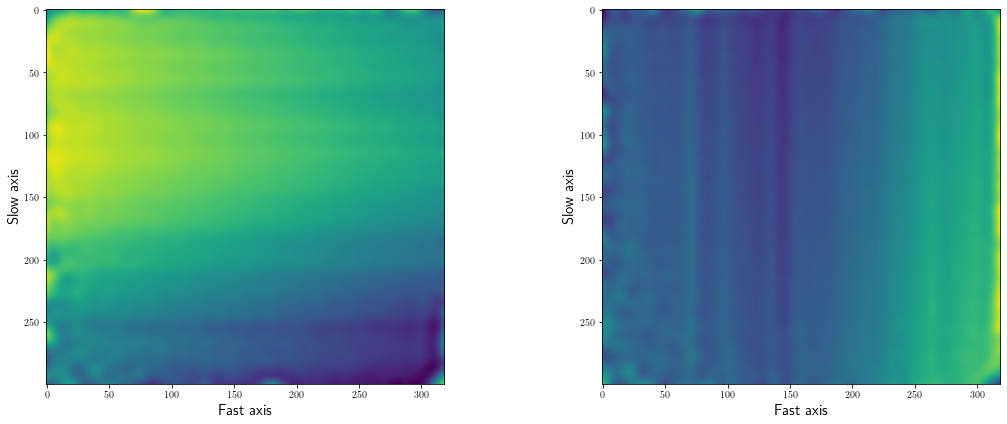

In [23]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

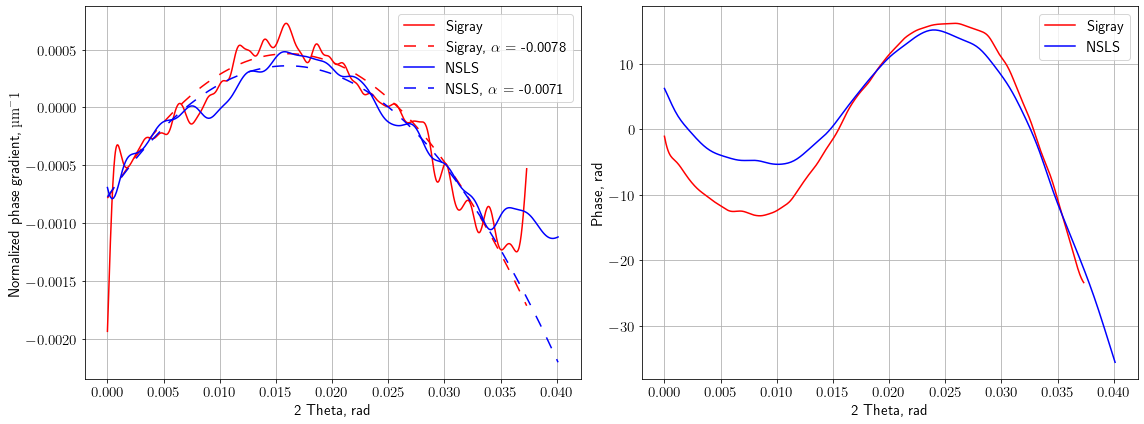

In [29]:
fit_obj = data.get_fit(center=150)
fit_obj = fit_obj.remove_linear_term()
fit_obj_nsls = fit_obj_nsls.crop_data([10, 240]).remove_linear_term()
fit_nsls = fit_obj_nsls.fit()
fit = fit_obj.crop_data([10, 650]).fit()

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.thetas, fit_obj.pixel_aberrations * fit_obj.defocus / fit_obj.distance,
             label='Sigray', c='r')
axes[0].plot(fit_obj.thetas, fit_obj.model(fit['fit']) * fit_obj.defocus / fit_obj.distance,
             label=fr"Sigray, $\alpha$ = {fit['c_3']:.4f}",
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj.thetas, fit_obj.phase, label='Sigray', c='r')

axes[0].plot(fit_obj_nsls.thetas,
             fit_obj_nsls.pixel_aberrations * fit_obj_nsls.defocus / fit_obj_nsls.distance,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.thetas,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.defocus / fit_obj_nsls.distance,
             label=fr"NSLS, $\alpha$ = {fit_nsls['c_3']:.4f}",
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.thetas, fit_obj_nsls.phase, label='NSLS', c='b')

axes[0].set_ylabel('Normalized phase gradient, \si{\micro\metre^-1}', fontsize=15)
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()